In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV

warnings.filterwarnings("ignore")


In [2]:
train_cv = pd.read_csv('train_adc/train.csv')
items = pd.read_csv('train_adc/item_data.csv')
view_logs = pd.read_csv('train_adc/view_log.csv')

print(train_cv.columns.tolist(),items.columns.tolist(),view_logs.columns.tolist())

['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version', 'is_4G', 'is_click'] ['item_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type'] ['server_time', 'device_type', 'session_id', 'user_id', 'item_id']


In [3]:
print("\nExact duplicates in train:", train_cv.duplicated().sum())
print("Exact duplicates in items:", items.duplicated().sum())
print("Exact duplicates in view_logs:", view_logs.duplicated().sum())

# Check if "train" has duplicate IDs (if ID column exists)
if 'id' in train_cv.columns:
    print("\nDuplicate train IDs:", train_cv['id'].duplicated().sum())


Exact duplicates in train: 0
Exact duplicates in items: 0
Exact duplicates in view_logs: 101126


In [5]:
view_logs = view_logs.drop_duplicates()
train_cv.shape , view_logs.shape

((237609, 7), (3017496, 5))

In [ ]:
# Check data types and missing values
for name, df in zip(['Train', 'Items', 'View Logs'], [train_cv, items, view_logs]):
    print(f"\n{name} Info:")
    display(df.info())
    print(f"\n{name} Nulls:\n{df.isnull().sum()}")


Train Nulls:
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

Items Nulls:
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64

View Logs Nulls:
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64


In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import shapiro, normaltest, probplot

# # Example: df is your DataFrame
# cols = ['avg_item_price', 'max_item_price']

# for col in cols:
#     print(f"\n--- Checking Normality for: {col} ---")
    
#     # Histogram
#     sns.histplot(train_cv[col].dropna(), kde=True)
#     plt.title(f"Histogram of {col}")
#     plt.show()
    
#     # Q-Q Plot
#     probplot(df[col].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot of {col}")
#     plt.show()
    
#     # Shapiro-Wilk test (good for small samples)
#     stat, p = shapiro(df[col].dropna())
#     print(f"Shapiro-Wilk Test → Statistic={stat:.3f}, p={p:.3f}")
    
#     # D’Agostino and Pearson’s test (good for larger samples)
#     stat, p = normaltest(df[col].dropna())
#     print(f"D’Agostino Test → Statistic={stat:.3f}, p={p:.3f}")
    
#     if p > 0.05:
#         print(f"{col} looks **normal** (fail to reject H0).")
#     else:
#         print(f"{col} is **not normal** (reject H0).")


In [7]:
# df['avg_item_price'].fillna(df['avg_item_price'].median(), inplace=True)
# df['max_item_price'].fillna(df['max_item_price'].median(), inplace=True)
# df.drop(columns=["item_price", "category_1", "category_2", "category_3", "product_type"], inplace=True)


In [6]:
train_cv['impression_time'] = pd.to_datetime(train_cv['impression_time'])
view_logs['server_time'] = pd.to_datetime(view_logs['server_time'])

In [7]:
# Merge view_logs with item data to enrich view log information
view_logs = view_logs.merge(items, on='item_id', how='left')

In [8]:
view_logs.duplicated().sum()

np.int64(0)

In [9]:
# Create user-level aggregated features from view logs without NaNs
user_view_agg = (
    view_logs.groupby('user_id', dropna=False)
    .agg({
        'item_id': lambda x: x.count(),  # count non-NaN
        'item_price': [
            lambda x: x.mean(skipna=True),
            lambda x: x.max(skipna=True)
        ],
        'category_1': lambda x: x.nunique(dropna=True),
        'category_2': lambda x: x.nunique(dropna=True),
        'category_3': lambda x: x.nunique(dropna=True),
        'product_type': lambda x: x.nunique(dropna=True),
    })
    .reset_index()
)

# Rename columns
user_view_agg.columns = [
    'user_id', 
    'total_views', 
    'avg_item_price', 
    'max_item_price',
    'unique_cat1', 
    'unique_cat2', 
    'unique_cat3', 
    'unique_product_types'
]

# Replace any remaining NaNs with 0 (e.g., for users with no price info)
user_view_agg = user_view_agg.fillna(0)


In [11]:
train_cv = train_cv.merge(user_view_agg, on='user_id', how='left')

In [12]:
train_cv = train_cv.merge(view_logs[['user_id', 'device_type']], on='user_id', how='left')

In [13]:
train_cv.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'total_views', 'avg_item_price', 'max_item_price',
       'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types',
       'device_type'],
      dtype='object')

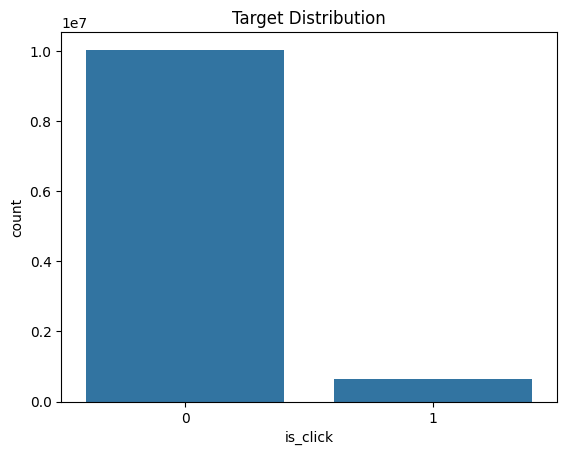

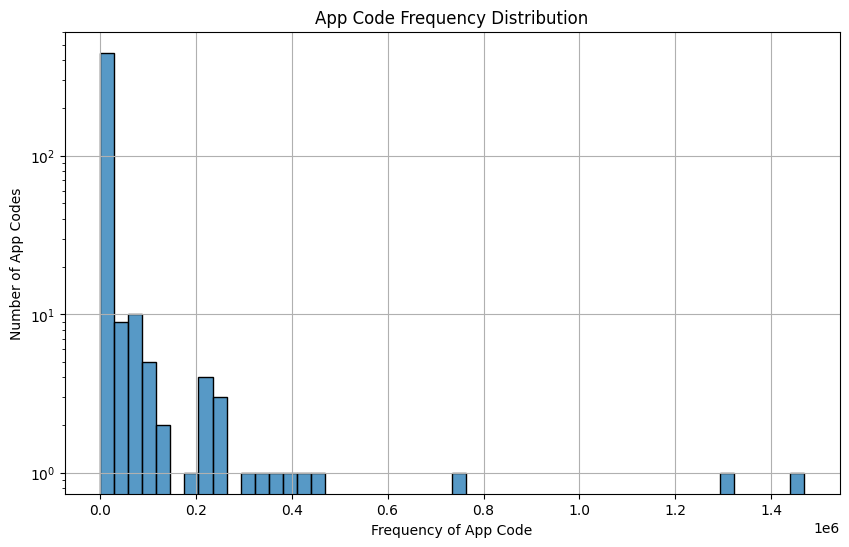

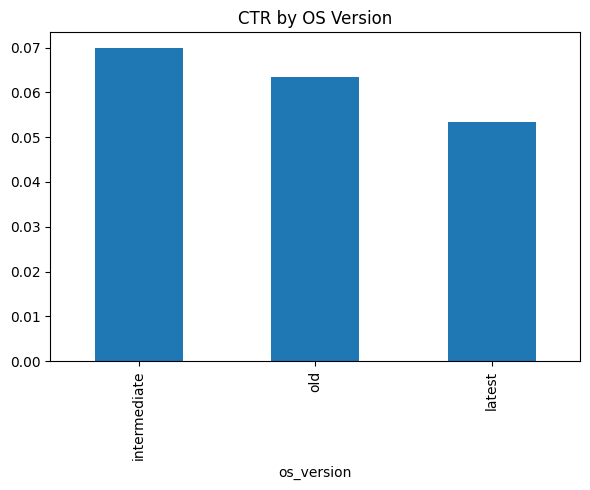

In [14]:
sns.countplot(data=train_cv, x='is_click')
plt.title('Target Distribution')

app_code_counts = train_cv['app_code'].value_counts()

# Plot the frequencies (log scale helps if highly skewed)
plt.figure(figsize=(10, 6))
sns.histplot(app_code_counts, bins=50, kde=False)
plt.title('App Code Frequency Distribution')
plt.xlabel('Frequency of App Code')
plt.ylabel('Number of App Codes')
plt.yscale('log')  # Optional: Log scale helps if data is very skewed
plt.grid(True)
plt.show()

# CTR by OS Version
plt.figure(figsize=(6, 5))
train_cv.groupby('os_version')['is_click'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('CTR by OS Version')
plt.tight_layout()

plt.show()

In [15]:
train_cv['impression_time'] = pd.to_datetime(train_cv['impression_time'])

train_cv['hour'] = train_cv['impression_time'].dt.hour
train_cv['dayofweek'] = train_cv['impression_time'].dt.dayofweek
train_cv['is_weekend'] = train_cv['dayofweek'].isin([5, 6]).astype(int)

In [16]:
cols_to_encode = ["os_version", "device_type"]

for col in cols_to_encode:
    mask = train_cv[col].apply(lambda x: isinstance(x, (list, tuple, np.ndarray)))
    if mask.any():
        print(f"Column '{col}' has array-like values at indices: {train_cv.index[mask].tolist()}")
        print(train_cv.loc[mask, col])

In [17]:
train_cv = train_cv.drop(index=224520)

In [18]:
le = LabelEncoder()
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' for dummy trap, sparse_output=False for DataFrame

for col in ['unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types']:
    train_cv[col] = train_cv[col].astype(str)  # If needed
    train_cv[col] = le.fit_transform(train_cv[col])
encoded_array = ohe.fit_transform(train_cv[cols_to_encode])
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=ohe.get_feature_names_out(cols_to_encode),
    index=train_cv.index
)
train_cv = pd.concat([train_cv.drop(columns=cols_to_encode), encoded_df], axis=1)


In [19]:
app_click_rate = train_cv.groupby('app_code')['is_click'].mean()
train_cv['app_code_click_rate'] = train_cv['app_code'].map(app_click_rate)

In [20]:
# Frequency of each app_code
app_freq = train_cv['app_code'].value_counts()

# Click rate per app_code
app_click_rate = train_cv.groupby('app_code')['is_click'].mean()

# Combine into one DataFrame
app_stats = pd.DataFrame({
    'frequency': app_freq,
    'click_rate': app_click_rate
})

# Mark rare
thresholds = [10,20,30,40,50]  # try 10, 30, 50, etc.
for threshold in thresholds:
    app_stats['is_rare'] = app_stats['frequency'] < threshold

    # Compare variance
    print("At Threshold ->",threshold)
    print("Click rate variance for frequent apps:", app_stats.loc[~app_stats['is_rare'], 'click_rate'].var())
    print("Click rate variance for rare apps:", app_stats.loc[app_stats['is_rare'], 'click_rate'].var())

    # Plot click rate vs frequency
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(8,5))
    # plt.scatter(app_stats['frequency'], app_stats['click_rate'], alpha=0.5)
    # plt.xscale('log')
    # plt.xlabel('Frequency (log scale)')
    # plt.ylabel('Click Rate')
    # plt.title('Click Rate vs App Code Frequency')
    # plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    # plt.legend()
    # plt.show()


At Threshold -> 10
Click rate variance for frequent apps: 0.028216636634328614
Click rate variance for rare apps: 0.04343434343434343
At Threshold -> 20
Click rate variance for frequent apps: 0.025553633561824135
Click rate variance for rare apps: 0.05392354124748493
At Threshold -> 30
Click rate variance for frequent apps: 0.022039304623800764
Click rate variance for rare apps: 0.06706756186493315
At Threshold -> 40
Click rate variance for frequent apps: 0.02214419774337628
Click rate variance for rare apps: 0.06007926268402907
At Threshold -> 50
Click rate variance for frequent apps: 0.021041592056470517
Click rate variance for rare apps: 0.060100518010297095


In [21]:
threshold = 40

# Count frequencies
app_freq = train_cv['app_code'].value_counts()

# Identify rare ones
rare_apps = app_freq[app_freq < threshold].index

# Create cleaned column
train_cv['app_code_cleaned'] = train_cv['app_code'].apply(lambda x: 'other' if x in rare_apps else x)

In [22]:
# Click rate after grouping
app_click_rate = train_cv.groupby('app_code_cleaned')['is_click'].mean()

# Map back to dataset
train_cv['app_code_click_rate'] = train_cv['app_code_cleaned'].map(app_click_rate)


In [23]:
train_cv.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'is_4G',
       'is_click', 'total_views', 'avg_item_price', 'max_item_price',
       'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types',
       'hour', 'dayofweek', 'is_weekend', 'os_version_latest',
       'os_version_old', 'device_type_iphone', 'device_type_web',
       'app_code_click_rate', 'app_code_cleaned'],
      dtype='object')

In [24]:
features = [
    'app_code', 'os_version_latest','os_version_old','is_4G',
    'hour', 'dayofweek', 'is_weekend',
    'device_type_iphone', 'device_type_web',
    'total_views', 'avg_item_price', 'max_item_price',
    'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types'
]
target = 'is_click'

In [25]:
train_cv = train_cv.iloc[:1000000]

In [39]:
train_cv = train_cv.drop_duplicates(subset=['impression_id'])


In [40]:
# Separate majority and minority classes
majority_class = train_cv[train_cv[target] == 0]
minority_class = train_cv[train_cv[target] == 1]

# Undersample majority class to match minority count
majority_class_undersampled = majority_class.sample(
    n=len(minority_class),
    random_state=42
)

# Combine minority class with undersampled majority class
train_cv_balanced = pd.concat([minority_class, majority_class_undersampled])

# Shuffle the resulting dataframe
train_cv_balanced = train_cv_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Before undersampling:", train_cv[target].value_counts())
print("After undersampling:", train_cv_balanced[target].value_counts())

# Now train_cv_balanced can be used for training


Before undersampling: is_click
0    20031
1     1016
Name: count, dtype: int64
After undersampling: is_click
1    1016
0    1016
Name: count, dtype: int64


In [41]:
X_train, X_test, y_train, y_test = train_test_split(train_cv_balanced[features], train_cv_balanced[target], test_size=0.3, random_state=42)

In [42]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(X_train[features])
poly_feature_names = poly.get_feature_names_out(X_train[features].columns)
X_train_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=X_train[features].index)

In [43]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 5️⃣ Feature Selection with Mutual Information
# Select top k features (max 30 or total available)
# mi_selector = SelectKBest(mutual_info_classif, k=min(30, train_cv[features].iloc[:10000].shape[1]))
mi_selector = SelectKBest(mutual_info_classif, k=min(30, X_train_poly.shape[1]))

# Fit selector on X, y
X_selected = mi_selector.fit_transform(X_train_poly, y_train)

# Get the names of selected features
selected_feature_names = X_train_poly.columns[mi_selector.get_support()]

# Replace X with selected features
# X = pd.DataFrame(X_selected, columns=selected_feature_names, index=train_cv[features].index)

print(f"✅ Selected top features using Mutual Information: {list(selected_feature_names)}")

✅ Selected top features using Mutual Information: ['app_code', 'total_views', 'unique_product_types', 'app_code^2', 'app_code os_version_old', 'app_code hour', 'app_code dayofweek', 'app_code device_type_web', 'app_code total_views', 'app_code max_item_price', 'app_code unique_cat1', 'app_code unique_cat3', 'app_code unique_product_types', 'os_version_latest max_item_price', 'os_version_old avg_item_price', 'os_version_old unique_cat2', 'os_version_old unique_cat3', 'hour device_type_iphone', 'hour unique_cat3', 'dayofweek unique_cat2', 'dayofweek unique_cat3', 'device_type_iphone max_item_price', 'total_views^2', 'total_views max_item_price', 'total_views unique_cat2', 'total_views unique_cat3', 'unique_cat1 unique_product_types', 'unique_cat2^2', 'unique_cat2 unique_product_types', 'unique_cat3 unique_product_types']


In [44]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(X_test[features])
poly_feature_names = poly.get_feature_names_out(X_test[features].columns)
X_test_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=X_test[features].index)

In [31]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix ,  roc_auc_score, roc_curve, precision_recall_curve
# import pandas as pd


# # 2. Baseline Model
# model = RandomForestClassifier( random_state=42,
#     n_estimators=50,       # fewer trees
#     max_depth=10,          # limit depth
#     n_jobs=-1 ,
#     class_weight='balanced'
#     )
# model.fit(X_train_poly[selected_feature_names], y_train)

# # 3. Predictions
# y_pred = model.predict(X_test_poly[selected_feature_names])
# y_proba = model.predict_proba(X_test_poly[selected_feature_names])[:, 1]

# # 4. Evaluation
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # 5. Feature Importance
# feat_importances = pd.Series(model.feature_importances_, index=X_train_poly[selected_feature_names].columns)
# feat_importances.nlargest(10).plot(kind='barh')

In [32]:
# # ✅ 3. ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# plt.figure(figsize=(6,5))
# plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_proba):.3f}")
# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

# # ✅ 4. Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, y_proba)
# plt.figure(figsize=(6,5))
# plt.plot(recall, precision, label="Precision-Recall Curve")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.show()

In [33]:
# from sklearn.metrics import (
#     accuracy_score, balanced_accuracy_score, precision_score, recall_score,
#     f1_score, matthews_corrcoef, confusion_matrix, classification_report,
#     brier_score_loss, roc_auc_score
# )
# metrics = {}

# # Basic scores
# metrics['Accuracy'] = accuracy_score(y_test, y_pred)
# metrics['Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred)
# metrics['Precision'] = precision_score(y_test, y_pred)
# metrics['Recall'] = recall_score(y_test, y_pred)
# metrics['F1 Score'] = f1_score(y_test, y_pred)
# metrics['MCC'] = matthews_corrcoef(y_test, y_pred)

# # Probability-based scores
# metrics['ROC AUC'] = roc_auc_score(y_test, y_proba)
# metrics['Brier Score'] = brier_score_loss(y_test, y_proba)

# # Display all metrics nicely
# metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
# print("\n=== Model Performance Metrics ===")
# print(metrics_df.round(4))

# # Detailed classification report
# print("\n=== Classification Report ===")
# print(classification_report(y_test, y_pred))

# # Confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# print("\n=== Confusion Matrix ===")
# print(cm)

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve, validation_curve , StratifiedKFold
# from sklearn.inspection import permutation_importance
# from sklearn.calibration import calibration_curve
# from sklearn.metrics import accuracy_score, roc_auc_score

# # ==========================
# # 1. Train/Test Performance Gap
# # ==========================
# y_train_pred = model.predict(X_train_poly[selected_feature_names])
# y_test_pred = model.predict(X_test_poly[selected_feature_names])

# train_acc = accuracy_score(y_train, y_train_pred)
# test_acc = accuracy_score(y_test, y_test_pred)

# print("Train Accuracy:", train_acc)
# print("Test Accuracy:", test_acc)
# print("Gap:", train_acc - test_acc)

# # ==========================
# # 2. Learning Curves
# # ==========================
# train_sizes, train_scores, test_scores = learning_curve(
#     model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 6)
# )

# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.figure(figsize=(8,5))
# plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation score")
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid()
# plt.show()

# # ==========================
# # 3. Validation Curve (example with max_depth)
# # ==========================
# param_range = np.arange(1, 15)
# train_scores, test_scores = validation_curve(
#     model, X_train, y_train, param_name="max_depth",
#     param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
# )

# train_mean = np.mean(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)

# plt.figure(figsize=(8,5))
# plt.plot(param_range, train_mean, label="Training score", marker='o')
# plt.plot(param_range, test_mean, label="Validation score", marker='o')
# plt.title("Validation Curve for max_depth")
# plt.xlabel("max_depth")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid()
# plt.show()

# # ==========================
# # 4. Permutation Importance
# # ==========================
# perm_importance = permutation_importance(model, X_test_poly[selected_feature_names], y_test, n_repeats=10, random_state=42, n_jobs=-1)
# sorted_idx = perm_importance.importances_mean.argsort()

# plt.figure(figsize=(8,5))
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
# plt.yticks(range(len(sorted_idx)), np.array(X_train_poly[selected_feature_names].columns)[sorted_idx])
# plt.title("Permutation Importance (Test Set)")
# plt.show()

# # ==========================
# # 5. Calibration Curve
# # ==========================
# if hasattr(model, "predict_proba"):
#     prob_pos = model.predict_proba(X_test_poly[selected_feature_names])[:, 1]
# else:
#     # Some models use decision_function instead
#     from sklearn.utils import check_array
#     prob_pos = model.decision_function(X_test_poly[selected_feature_names])
#     prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

# fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

# plt.figure(figsize=(8,5))
# plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
# plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
# plt.xlabel("Mean predicted value")
# plt.ylabel("Fraction of positives")
# plt.title("Calibration Curve")
# plt.legend()
# plt.grid()
# plt.show()


In [45]:
from sklearn.model_selection import learning_curve, validation_curve , StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix, classification_report,
    brier_score_loss, roc_auc_score
)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "roc_auc": [],
    "conf_matrix": []
}
train_scores, test_scores = [], []
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_poly[selected_feature_names], y_train), start=1):
    X_train_cv = X_train_poly[selected_feature_names].iloc[train_idx]
    X_test_cv  = X_train_poly[selected_feature_names].iloc[test_idx]
    y_train_cv = y_train.iloc[train_idx]
    y_test_cv  = y_train.iloc[test_idx]
    
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train_cv, y_train_cv)

    # Predictions
    y_train_pred = model.predict(X_train_cv)
    y_test_pred  = model.predict(X_test_cv)
    if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_cv)[:, 1]
    else:
        y_proba = None
    
    # Append metrics
    metrics["accuracy"].append(accuracy_score(y_test_cv, y_test_pred))
    metrics["precision"].append(precision_score(y_test_cv, y_test_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test_cv, y_test_pred, zero_division=0))
    metrics["f1"].append(f1_score(y_test_cv, y_test_pred, zero_division=0))

    if y_proba is not None:
        metrics["roc_auc"].append(roc_auc_score(y_test_cv, y_proba))
    else:
        metrics["roc_auc"].append(np.nan)

    metrics["conf_matrix"].append(confusion_matrix(y_test_cv, y_test_pred))

    # Mean results
for m in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print(f"{m}: {np.nanmean(metrics[m]):.4f}")

print("\nConfusion Matrices (per fold):")
for i, cm in enumerate(metrics["conf_matrix"], 1):
    print(f"Fold {i}:\n{cm}\n")

accuracy: 0.5654
precision: 0.5693
recall: 0.6066
f1: 0.5865
roc_auc: 0.5924

Confusion Matrices (per fold):
Fold 1:
[[36 34]
 [27 46]]

Fold 2:
[[24 46]
 [26 47]]

Fold 3:
[[41 29]
 [29 43]]

Fold 4:
[[34 36]
 [30 42]]

Fold 5:
[[39 31]
 [25 47]]

Fold 6:
[[35 35]
 [34 38]]

Fold 7:
[[45 25]
 [29 43]]

Fold 8:
[[37 33]
 [32 40]]

Fold 9:
[[35 35]
 [26 46]]

Fold 10:
[[40 30]
 [26 46]]



In [36]:
# 1. Check for duplicate rows across the dataset
print("Duplicates in X:", X_train_poly[selected_feature_names].duplicated().sum())

# 2. Check if any test fold contains exact rows from the train fold
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train_poly[selected_feature_names], y_train), 1):
    overlap = np.intersect1d(train_idx, test_idx).size
    print(f"Fold {fold} overlap in indices:", overlap)

# 3. Look for ID-like columns (user_id, timestamp, etc.)
if isinstance(X_train_poly[selected_feature_names], pd.DataFrame):
    for col in X_train_poly[selected_feature_names].columns:
        if X_train_poly[selected_feature_names][col].nunique() == len(X_train_poly[selected_feature_names]):
            print(f"Potential ID column: {col}")

# 4. Check correlation of each feature with target (too high = suspicious)
if isinstance(X_train_poly[selected_feature_names], pd.DataFrame):
    corrs = X_train_poly[selected_feature_names].corrwith(pd.Series(y_train))
    print("\nFeatures highly correlated with target:")
    print(corrs[abs(corrs) > 0.95])


Duplicates in X: 77029
Fold 1 overlap in indices: 0
Fold 2 overlap in indices: 0
Fold 3 overlap in indices: 0
Fold 4 overlap in indices: 0
Fold 5 overlap in indices: 0

Features highly correlated with target:
Series([], dtype: float64)


In [37]:
dup_with_label = pd.concat([X_train_poly[selected_feature_names], y_train.reset_index(drop=True)], axis=1)
dup_count = dup_with_label.duplicated().sum()
print(f"Exact duplicates including labels: {dup_count}")


Exact duplicates including labels: 91881
